In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from funciones import formato_fechas
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv('Datos/Datos UX/page_views_2.csv', sep=';', parse_dates=['event_timestamp_'])
df.drop(columns=['event_date_','event_name'], inplace=True)
df = df.sort_values(by=['user_id', 'event_timestamp_'])

In [9]:
orden_quiz = ["quiz_leisure", "quiz_work", "quiz_fit","quiz_highlight","quiz_bodyShape", "quiz_eyes", "quiz_hair",
              "quiz_sizes", "quiz_measurements", "quiz_focus", "quiz_adventurous", "quiz_styles",
              "quiz_prices", "quiz_avoid", "quiz_footwear", "quiz_you", "quiz_photos", "quiz_social", "quiz_signUp"]
mapeo = {step: i for i, step in enumerate(orden_quiz)}

## EXPLORACION INICIAL

In [4]:
usuarios_totales = df['user_id'].nunique()
usuarios_totales

41

In [5]:
preguntas_totales = df['section'].nunique()
preguntas_totales

19

Se considera que han acabado, aquellas personas que llegan al signup y no realizan mas pasos

In [6]:
last_events = df.groupby('user_id').tail(1).copy()
usuarios_exito_real = last_events[last_events['section'] == 'quiz_signUp']['user_id'].unique()
len(usuarios_exito_real)

32

# Usuarios Que Han Realizado el Test

In [12]:
secciones_obligatorias = set(orden_quiz) - {'quiz_leisure'}

analisis = []
df_exitosos = df[df['user_id'].isin(usuarios_exito_real)]

for user in usuarios_exito_real:
    secciones_visitadas = set(df_exitosos[df_exitosos['user_id'] == user]['section'].unique())    
    falta = secciones_obligatorias - secciones_visitadas
    
    analisis.append({
        'user_id': user,
        'Hizo_Todo': len(falta) == 0,
        'Secciones_Saltadas': list(falta)
    })

df_completado = pd.DataFrame(analisis)

print(f"Total Usuarios que terminaron: {len(df_completado)}")
print(f"Usuarios con recorrido perfecto: {len(df_completado[df_completado['Hizo_Todo']])}")
print(f"Usuarios con saltos: {len(df_completado[~df_completado['Hizo_Todo']])}")

print("\n¿QUÉ SE SALTA LA GENTE QUE TERMINA?")
print(df_completado[~df_completado['Hizo_Todo']][['user_id', 'Secciones_Saltadas']].to_string(index=False))

Total Usuarios que terminaron: 32
Usuarios con recorrido perfecto: 22
Usuarios con saltos: 10

¿QUÉ SE SALTA LA GENTE QUE TERMINA?
                         user_id Secciones_Saltadas
1932240bef894979be69257cc5431843    [quiz_footwear]
287cd4480785430b83bb19f93318a7b7    [quiz_footwear]
28afb6f2fecb45508fb35ed818927b57    [quiz_footwear]
5379734ea78c4b0f9580fb994ac93510    [quiz_footwear]
90a01965db9a4092a66ac88a6906ab68    [quiz_footwear]
963c4eb5c1cd45aebfd2e6d184becd5e    [quiz_footwear]
a99226f446db4bc4aa8f69260a228ba8    [quiz_footwear]
c122da2281a540c8a9fdac722a0c4b7e    [quiz_footwear]
e0916cdf04854e68843f08688da90679    [quiz_footwear]
f220a4ac51cd42bfb73714a4edd45b9e    [quiz_footwear]


# Mediana de Preguntas

In [13]:
df['siguiente_hora'] = df.groupby('user_id')['event_timestamp_'].shift(-1)
df['segundos'] = (df['siguiente_hora'] - df['event_timestamp_']).dt.total_seconds()

# Filtramos tiempos válidos (Preguntas de +30min se borran)
df_tiempos = df[df['segundos'] < 60*30].copy()
tabla_tiempos = df_tiempos.groupby('section')['segundos'].agg(['median', 'count']).reset_index()
tabla_tiempos.columns = ['section', 'Mediana (seg)', 'Usuarios_Medibles']

tabla_trafico = df.groupby('section')['user_id'].count().reset_index()
tabla_trafico.columns = ['section', 'Trafico_Total_Real']

resultado = pd.merge(tabla_trafico, tabla_tiempos, on='section', how='left')

resultado['section'] = pd.Categorical(resultado['section'], categories=orden_quiz, ordered=True)
resultado = resultado.sort_values('section')

print(resultado[['section', 'Trafico_Total_Real', 'Mediana (seg)']].to_string(index=False))

          section  Trafico_Total_Real  Mediana (seg)
     quiz_leisure                  24      11.248215
        quiz_work                  45       9.181293
         quiz_fit                  44      16.823730
   quiz_highlight                  44      20.634527
   quiz_bodyShape                  44      30.371002
        quiz_eyes                  43       9.158109
        quiz_hair                  46       6.682356
       quiz_sizes                  44      27.590783
quiz_measurements                  43      12.242307
       quiz_focus                  41      16.643335
 quiz_adventurous                  44      22.807763
      quiz_styles                  47      51.587092
      quiz_prices                  44      11.857911
       quiz_avoid                  42      18.498041
    quiz_footwear                  30      27.532795
         quiz_you                  42      19.043753
      quiz_photos                  42      54.285818
      quiz_social                  42      10.

Minimo tiene que haber 41 respuestas, a no ser que hayan abandonado el test

Explicar porque se usa la mediana y no la media

Es normal que en preguntas simples como color de ojos o de pelo las respuestas tengan una duracion mas corta . INSTINTIVAS

En otras preguntas como tallas/sizes es normal que tarden mas tiempo, ya que dentro de esa pregunta hay ¿subpreguntas?

Styles/Photos es tambien normal ya que son preguntas que requieren mas atencion del cliente, ya que hay imagenes que te ayudan a poder responder mejor las preguntas. REFLEXIVAS

Hay pregunta de marcas en el test lookiero --> En el csv no hay respuestas  ////// Hay pregunta de photos en el csv --> En el test de lookiero no hay

En calzado hay una bajada de respuestas????? Pruebas de Testeo o Oportunidad de Poder Saltar la Pregunta

------------------------

In [14]:
UMBRAL_SEGUNDOS = 60 * 60  # 60 minutos

df['prev_timestamp'] = df.groupby('user_id')['event_timestamp_'].shift(1)
df['prev_section'] = df.groupby('user_id')['section'].shift(1)
df['diff_seconds'] = (df['event_timestamp_'] - df['prev_timestamp']).dt.total_seconds()
df_retorno = df[df['diff_seconds'] > UMBRAL_SEGUNDOS].copy()

lista_analisis = []

for idx, row in df_retorno.iterrows():
    user = row['user_id']
    fecha_retorno = row['event_timestamp_']
    
    # Busca el siguiente retorno del usuario -> Cuando vuelve?
    proximos_retornos = df_retorno[(df_retorno['user_id'] == user) & (df_retorno['event_timestamp_'] > fecha_retorno)].sort_values('event_timestamp_')
    
    if not proximos_retornos.empty:
        fecha_limite = proximos_retornos.iloc[0]['event_timestamp_']
        # Filtramos todos los eventos de esa sesión
        eventos_sesion = df[(df['user_id'] == user) & (df['event_timestamp_'] >= fecha_retorno) & (df['event_timestamp_'] < fecha_limite)]
    else:
        eventos_sesion = df[(df['user_id'] == user) & (df['event_timestamp_'] >= fecha_retorno)]
    
    # Comprobar si el ultimo evento es signUP para marcar si ha completado despues de volver
    if not eventos_sesion.empty:
        ultimo_evento_sesion = eventos_sesion.iloc[-1]['section']
        completo = "SÍ" if ultimo_evento_sesion == 'quiz_signUp' else "NO"
    else:
        completo = "NO"
    
    lista_analisis.append({
        'Usuario': user,
        'Abandono_en': row['prev_section'],
        'Volvio_en': row['section'],
        'Tiempo_Ausente': formato_fechas(row['diff_seconds']),
        'Completó': completo})

df_resultado_retorno = pd.DataFrame(lista_analisis)

# 3. ANÁLISIS DE CHURN REAL (NUNCA COMPLETARON)
last_events_global = df.groupby('user_id').tail(1).copy()
usuarios_exito_real_ids = last_events_global[last_events_global['section'] == 'quiz_signUp']['user_id'].unique()
# Filtramos para quedarnos con los que NO son exitosos reales
# Esto incluye a los que nunca llegaron Y a los falsos positivos (llegaron y se fueron)
df_churn_real = last_events_global[~last_events_global['user_id'].isin(usuarios_exito_real_ids)].copy()
# Creamos el ranking de secciones "mortales"
ranking_fugas = df_churn_real['section'].value_counts().reset_index()
ranking_fugas.columns = ['Seccion_Mortal', 'Usuarios_Perdidos']
ranking_fugas['%_Total'] = (ranking_fugas['Usuarios_Perdidos'] / len(df_churn_real) * 100).round(2)

# 4. MOSTRAR RESULTADOS
print(f"1. ANÁLISIS DE RETORNOS")
recuperados = len(df_resultado_retorno[df_resultado_retorno['Completó']=='SÍ'])
total_retornos = len(df_resultado_retorno)

print(f"Pausas largas >1H : {total_retornos}")
print(f"Sesiones recuperadas: {recuperados} ({recuperados/total_retornos*100:.1f}%)")

cols_retorno = ['Usuario', 'Abandono_en', 'Volvio_en', 'Tiempo_Ausente', 'Completó']
print("\nDetalle de últimos casos:")
print(df_resultado_retorno[cols_retorno].to_string(index=False))

print("\n" + "-"*100 + "\n")

print(f"2. ANÁLISIS DE CHURN REAL (Abandonaron y nunca terminaron)")
print(f"Total Usuarios Fallidos: {len(df_churn_real)}")

print("\nTop 5 Secciones donde se pierden:")
print(ranking_fugas.head(5).to_string(index=False))

1. ANÁLISIS DE RETORNOS
Pausas largas >1H : 11
Sesiones recuperadas: 5 (45.5%)

Detalle de últimos casos:
                         Usuario       Abandono_en         Volvio_en Tiempo_Ausente Completó
08524cc6b3544d65af7faa39e9abd3f2       quiz_signUp       quiz_signUp         5h 28m       SÍ
287cd4480785430b83bb19f93318a7b7         quiz_hair         quiz_work       7d 1h 5m       SÍ
33354fc7eefa4f23a7cda6c23fc86ee6         quiz_work      quiz_leisure         9h 48m       SÍ
4fcccc46bdd64ef9a4ca06936adcc718      quiz_leisure      quiz_leisure        11h 24m       NO
4fcccc46bdd64ef9a4ca06936adcc718      quiz_leisure      quiz_leisure        19h 35m       NO
4fcccc46bdd64ef9a4ca06936adcc718       quiz_photos          quiz_you         1h 22m       NO
a7c3e11d30ab4d3b893c9528f9403532      quiz_leisure      quiz_leisure     34d 4h 37m       NO
d5bca4c6324a43e1867c2e9a36575fb3       quiz_signUp      quiz_leisure    10d 20h 25m       NO
e9e6c08704864b8b84897ecfbae1921b        quiz_sizes quiz_m

In [15]:
visitas_totales = df.groupby(['user_id', 'section']).size().reset_index(name='visits')

# Filtramos aquellos que visitan > 1 vez la misma sección
revisitas = visitas_totales[visitas_totales['visits'] > 1]
conteo_revisitas = revisitas['section'].value_counts().reset_index()
conteo_revisitas.columns = ['section', 'users_looping']
print("\n5. Revisitas")
print(conteo_revisitas.to_string(index=False))


5. Revisitas
          section  users_looping
   quiz_bodyShape              7
        quiz_work              7
   quiz_highlight              7
       quiz_sizes              6
      quiz_styles              6
        quiz_hair              6
        quiz_eyes              6
     quiz_leisure              6
         quiz_fit              6
      quiz_prices              6
 quiz_adventurous              5
       quiz_avoid              5
      quiz_signUp              5
quiz_measurements              5
      quiz_photos              5
         quiz_you              5
    quiz_footwear              4
       quiz_focus              4
      quiz_social              4


In [16]:
transitions = []

for uid, grp in df.groupby('user_id'):
    sections = grp['section'].tolist()
    for a,b in zip(sections, sections[1:]):
        transitions.append((a,b))

trans_df = pd.DataFrame(transitions, columns=['from','to'])

matriz = pd.crosstab(trans_df['from'], trans_df['to'])
M = matriz.to_numpy()

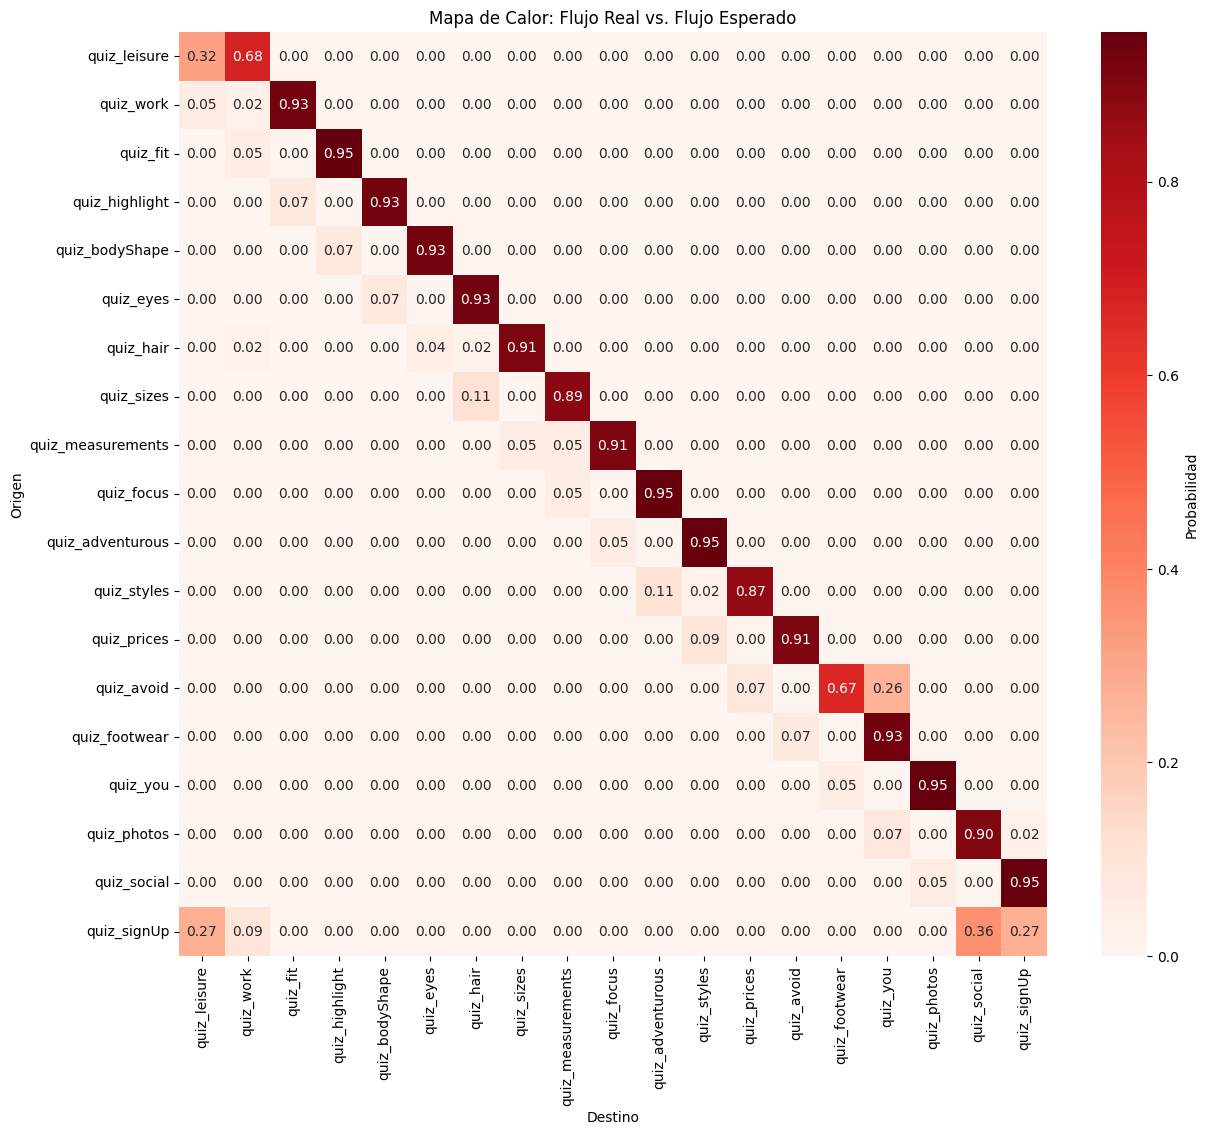

In [17]:
matriz_ordenada = matriz.reindex(index=orden_quiz, columns=orden_quiz, fill_value=0)
suma_filas = matriz_ordenada.sum(axis=1)
prob_matriz = matriz_ordenada.div(suma_filas.replace(0, 1), axis=0)

plt.figure(figsize=(14, 12))
sns.heatmap(prob_matriz, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Probabilidad'})
plt.title("Mapa de Calor: Flujo Real vs. Flujo Esperado")
plt.ylabel("Origen")
plt.xlabel("Destino")
plt.show()

En quiz_signUp muchos vuelven a quiz_leisure, puede ser que haya un boton de volver al inicio y vuelvan para revisar el cuestionario

El 26% pasan de quiz_avoid a quiz_you, saltandose footwear --> ERROR O SE PUEDE SALTAR DIRECTAMENTE ESA PREGUNTA?

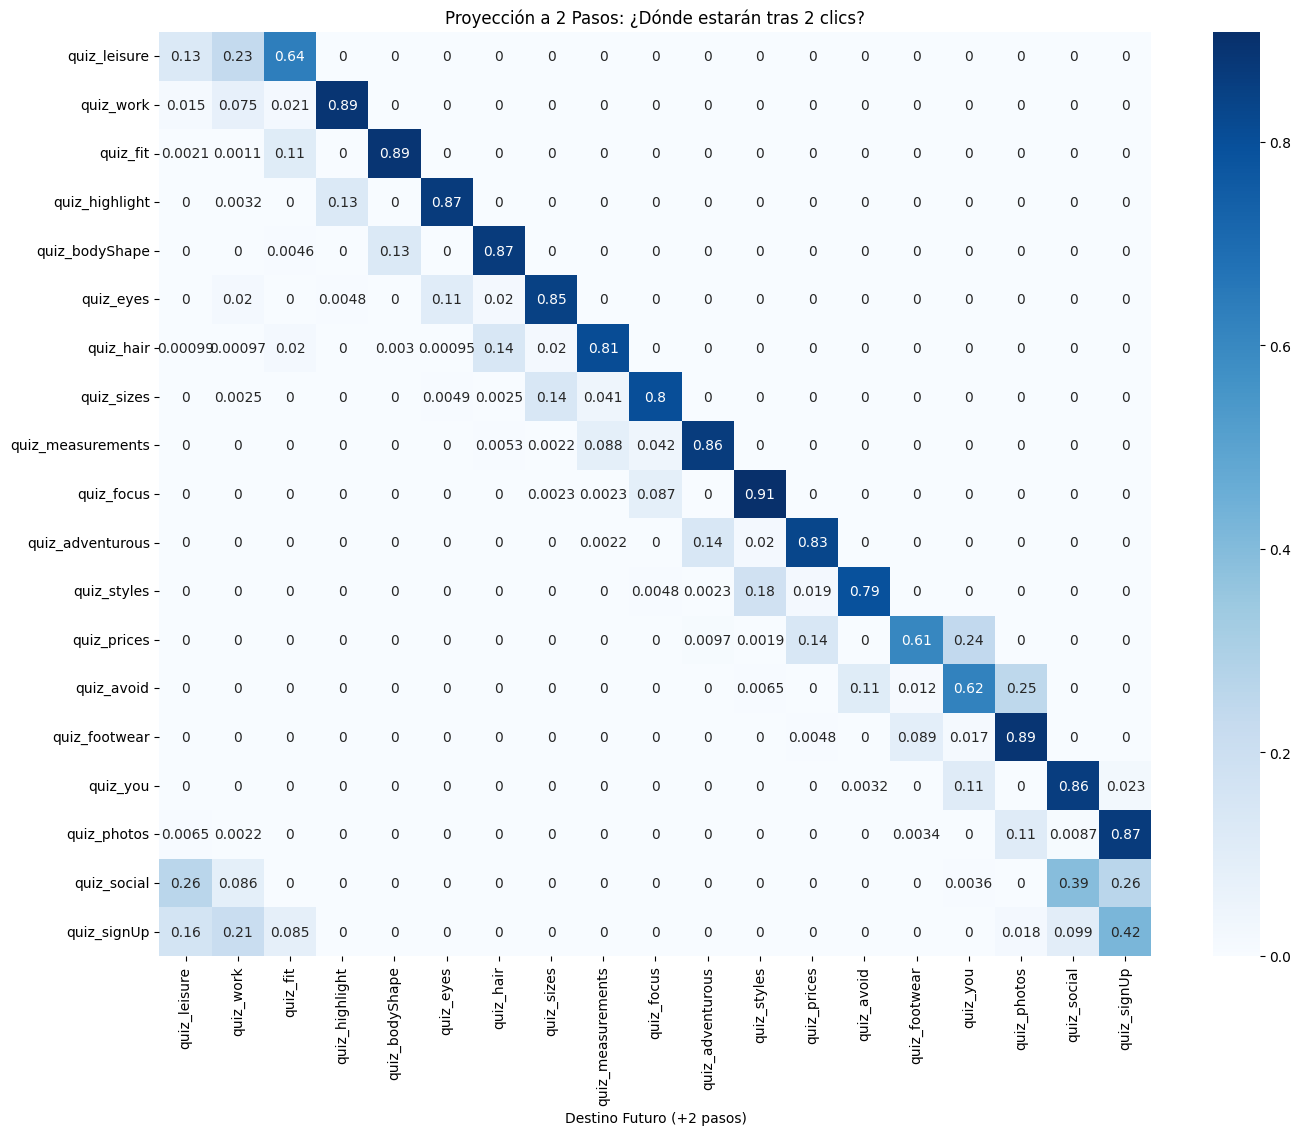

In [ ]:
M_prob = prob_matriz.to_numpy() 
M2_prob = M_prob @ M_prob
df_m2 = pd.DataFrame(M2_prob, index=orden_quiz, columns=orden_quiz)

plt.figure(figsize=(16, 12))
sns.heatmap(df_m2, cmap="Blues", annot=True)
plt.title("Proyección a 2 Pasos: ¿Dónde estarán tras 2 clics?")
plt.xlabel("Destino Futuro (+2 pasos)")
plt.show()

## Resumen
Mejora Futura -> Mostrar Resumen Cuando Termine y se Registre (Evitar que vuelvan + Obtener info. si se registran)

In [18]:
# NUEVO ANÁLISIS: MOMENTOS DE LA VERDAD (Time-to-Event)
# 1. Recalcular sesiones por si acaso (asegura integridad)
df['new_session'] = (df['segundos'] > 3600) | (df['segundos'].isna())
df['session_id'] = df.groupby('user_id')['new_session'].cumsum()

# 2. Calcular Duración Real en cada Pantalla
df['next_timestamp'] = df.groupby(['user_id', 'session_id'])['event_timestamp_'].shift(-1)
df['duration'] = (df['next_timestamp'] - df['event_timestamp_']).dt.total_seconds()

# 3. Clasificar el Movimiento (Forward, Backward, Loop, Exit)
df['next_section'] = df.groupby(['user_id', 'session_id'])['section'].shift(-1)

# Mapeamos secciones al ranking numérico usando 'orden_quiz'
section_rank = {sec: i for i, sec in enumerate(orden_quiz)}
df['rank_current'] = df['section'].map(section_rank)
df['rank_next'] = df['next_section'].map(section_rank)

def classify_movement(row):
    if pd.isna(row['next_section']): return 'Exit' # Abandono
    if pd.isna(row['rank_current']) or pd.isna(row['rank_next']): return 'Unknown'
        
    diff = row['rank_next'] - row['rank_current']
    
    if diff == 0: return 'Loop'     
    elif diff > 0: return 'Forward' 
    else: return 'Backward'         

df['movement_type'] = df.apply(classify_movement, axis=1)

# ==========================================
# 4. TABLA 1: TIEMPO DE DECISIÓN + CONTEO
# ==========================================
print("\n--- 1. TIEMPO DE DECISIÓN: Mediana y Volumen de Usuarios (Ordenado por Quiz) ---")

# Filtramos datos válidos
df_decision = df[df['movement_type'].isin(['Forward', 'Backward', 'Loop']) & (df['duration'] < 3600)].copy()

# Agrupamos
summary = df_decision.groupby(['section', 'movement_type'])['duration'].agg(['median', 'count']).unstack()

# Aplanamos nombres de columnas
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]

# Renombramos
rename_map = {
    'median_Forward': 'Avanza_Mediana', 'count_Forward': 'Avanza_Usuarios',
    'median_Backward': 'Retrocede_Mediana', 'count_Backward': 'Retrocede_Usuarios',
    'median_Loop': 'Bucle_Mediana', 'count_Loop': 'Bucle_Usuarios'
}
summary = summary.rename(columns=rename_map)

# Filtramos y ordenamos según 'orden_quiz'
# Esta lista 'valid_sections' ya se genera en el orden correcto
valid_sections = [s for s in orden_quiz if s in summary.index]

# Muestra final: SIN sort_values para mantener el orden de 'valid_sections'
display(summary.loc[valid_sections].fillna('-').round(1))


--- 1. TIEMPO DE DECISIÓN: Mediana y Volumen de Usuarios (Ordenado por Quiz) ---


,Retrocede_Mediana,Avanza_Mediana,Bucle_Mediana,Retrocede_Usuarios,Avanza_Usuarios,Bucle_Usuarios
section,,,,,,
quiz_leisure,-,10.591548,521.207576,-,13.0,2.0
quiz_work,0.0,9.181293,22.346653,1.0,41.0,1.0
quiz_fit,0.0,17.518159,-,1.0,41.0,-
quiz_highlight,4.978966,20.815415,-,2.0,41.0,-
quiz_bodyShape,5.816326,31.050053,-,3.0,41.0,-
quiz_eyes,0.0,10.116875,-,3.0,40.0,-
quiz_hair,5.752634,6.682356,-,2.0,41.0,-
quiz_sizes,12.21062,29.548836,-,5.0,38.0,-
quiz_measurements,0.0,12.264194,32.43816,2.0,39.0,1.0


# Tabla 1
Conclusiones Clave --> Me dice la mediana de tiempo de los usuarios en funcion de la accion que toman (Mantienen, Retroceden o Avanzan)
El "Bloqueo Técnico" en quiz_photos:

Dato: Los usuarios que retroceden tardan 460 segundos (casi 8 minutos), mientras que los que avanzan tardan solo 61 segundos.

Diagnóstico: ¡Esto es crítico! Nadie tarda 8 minutos simplemente para "pensárselo". Esto indica que el usuario quiere avanzar, lo intenta, falla (quizás el uploader no funciona o es lento), se frustra esperando y finalmente se rinde y vuelve atrás.

Acción: Revisa urgentemente la funcionalidad de carga de fotos, especialmente en móviles.

El "Susto Inmediato" en quiz_styles:

Dato: Los que retroceden lo hacen en 5.7 segundos. Los que avanzan se toman 60 segundos para elegir.

Diagnóstico: Aquí el retroceso es mental, no técnico. El usuario llega, ve las opciones y piensa "Uf, esto no encaja con lo que puse antes" (probablemente en quiz_adventurous). Vuelven atrás rápido para corregir su perfil anterior. Es un comportamiento sano de "ajuste".

Dudas de Auto-Percepción en quiz_sizes:

Dato: Retroceden en 12 segundos vs. avanzan en 29 segundos.

Diagnóstico: Similar a estilos. Si no ven su talla exacta o dudan, vuelven rápido a quiz_bodyShape para ver si cambiando su forma de cuerpo aparecen otras opciones de talla.

Fluidez General:

En la mayoría de las otras preguntas (quiz_work, quiz_eyes, etc.), los tiempos de avance son rápidos (10-20 segundos), lo que indica que las preguntas son claras y fáciles de responder.